# Synthetic data test: Sensitivity to interfering sources - Part 1 - Dipoles

The main goal of this synthetic is to show that the method works better than other Euler methods when there is interference from other sources in the data window. It uses dipole sources.

In [1]:
from pathlib import Path
import numpy as np
from IPython.display import Image
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler
import warnings

In [2]:
warnings.filterwarnings("ignore")

## Create a model and data

Make a model from a dipole and add a base level. We won't use noise in this example to isolate the effect of interference from the effect of noise.

Number of data: 2346


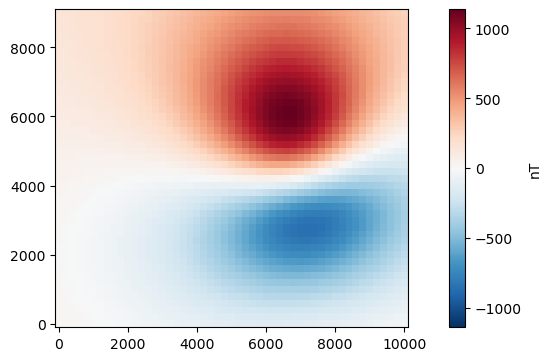

In [3]:
region = [0, 10e3, 0, 9e3]
height = 400
spacing = 200
coordinates = vd.grid_coordinates(region, spacing=spacing, extra_coords=height)
intensity, inclination, declination = 5e11, -30, -10
true_coordinates = (7e3, 4e3, -3e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=true_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(intensity, inclination, declination),
    field="b",
)
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))

# Add the base level
base_level = 100  # nT
magnetic_anomaly += base_level

print(f"Number of data: {magnetic_anomaly.size}")

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5), layout="constrained")
ax.set_aspect("equal")
scale = vd.maxabs(magnetic_anomaly)
tmp = ax.pcolormesh(
    *coordinates[:2], magnetic_anomaly, cmap="RdBu_r", vmin=-scale, vmax=scale
)
fig.colorbar(tmp, label="nT")
plt.show()

Make several datasets by adding an interfering source that gets closer and closer to the main source.

In [4]:
eastings = vd.line_coordinates(region[0] - 1e3, true_coordinates[0] - 2e3, spacing=200)
n_datasets = eastings.size
datasets_raw = []
interf_north = true_coordinates[1] + 1e3
interf_up = -1.5e3

for easting in eastings:    
    magnetic_field = hm.dipole_magnetic(
        coordinates,
        dipoles=(easting, interf_north, interf_up),
        magnetic_moments=hm.magnetic_angles_to_vec(5e10, inclination, -30),
        field="b",
    )
    datasets_raw.append(
        magnetic_anomaly + sum(b * f for b, f in zip(magnetic_field, main_field))
    )

Now we can make an `xarray.Dataset` for the grid and calculate the first-order derivatives.

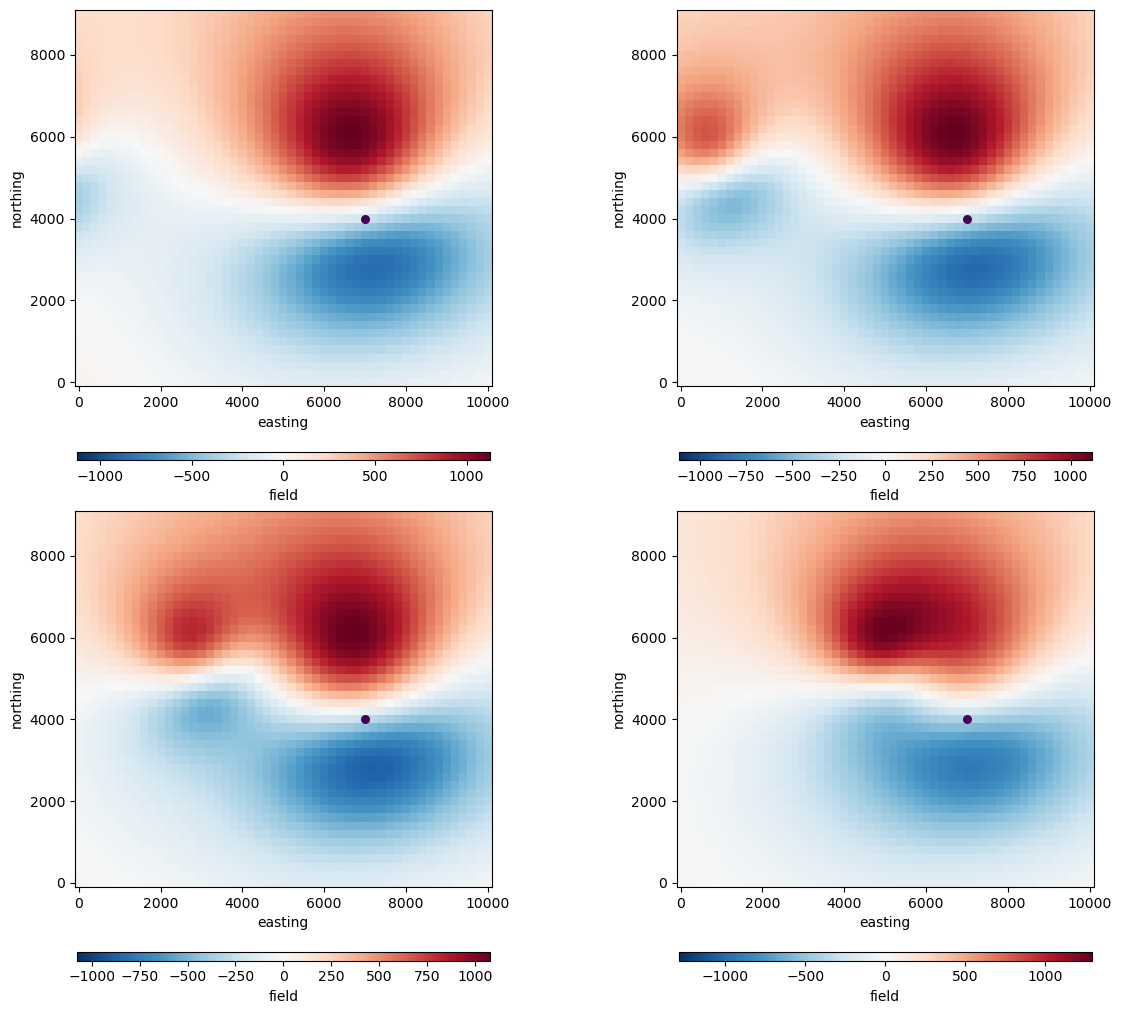

In [5]:
datasets = []
for raw in datasets_raw:
    data = vd.make_xarray_grid(
        coordinates[:2], (raw, coordinates[-1]), data_names=["field", "height"]
    )
    pad_width = {
        "easting": data.easting.size // 2,
        "northing": data.northing.size // 2,
    }
    data["deriv_east"] = hm.derivative_easting(data.field)
    data["deriv_north"] = hm.derivative_northing(data.field)
    data["deriv_up"] = xrft.unpad(
        hm.derivative_upward(
            xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
        ),
        pad_width,
    )
    data = data.assign_coords(height=data.height)
    datasets.append(data)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), layout="constrained")
for i, ax in zip([0, n_datasets // 3, 2 * n_datasets // 3, -1], axes.ravel()):
    datasets[i].field.plot.pcolormesh(
        ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50, shrink=0.7)
    )
    ax.set_aspect("equal")
    tmp = ax.scatter(*true_coordinates[:2], c=true_coordinates[2], s=30)
plt.show()

## Run the Euler methods

Run Euler deconvolution, finite-difference Euler deconvolution [(Gerovska et al., 2005)](https://doi.org/10.1007/s00024-004-2623-1), and Euler inversion on a single data window. For Euler deconvolution, use the correct structural index of 3.

In [6]:
def euler_inversion_si_estimate(data):
    """
    Run Euler inversion with different SI and estimate the best one.
    """
    estimates = []
    for si in euler.STRUCTURAL_INDICES:
        estimates.append(euler.EulerInversion(structural_index=si).fit_grid(data))
    rmse = [ei.data_misfit_[-1] for ei in estimates]
    return estimates[np.argmin(rmse)]


deconv = [
    euler.EulerDeconvolution(structural_index=3).fit_grid(data) for data in datasets
]
deconvfd = [euler.EulerDeconvolutionFD().fit_grid(data) for data in datasets]
inversion = [euler_inversion_si_estimate(data) for data in datasets]

## Make a figure for the paper

Show the observed data and the estimates from all methods.

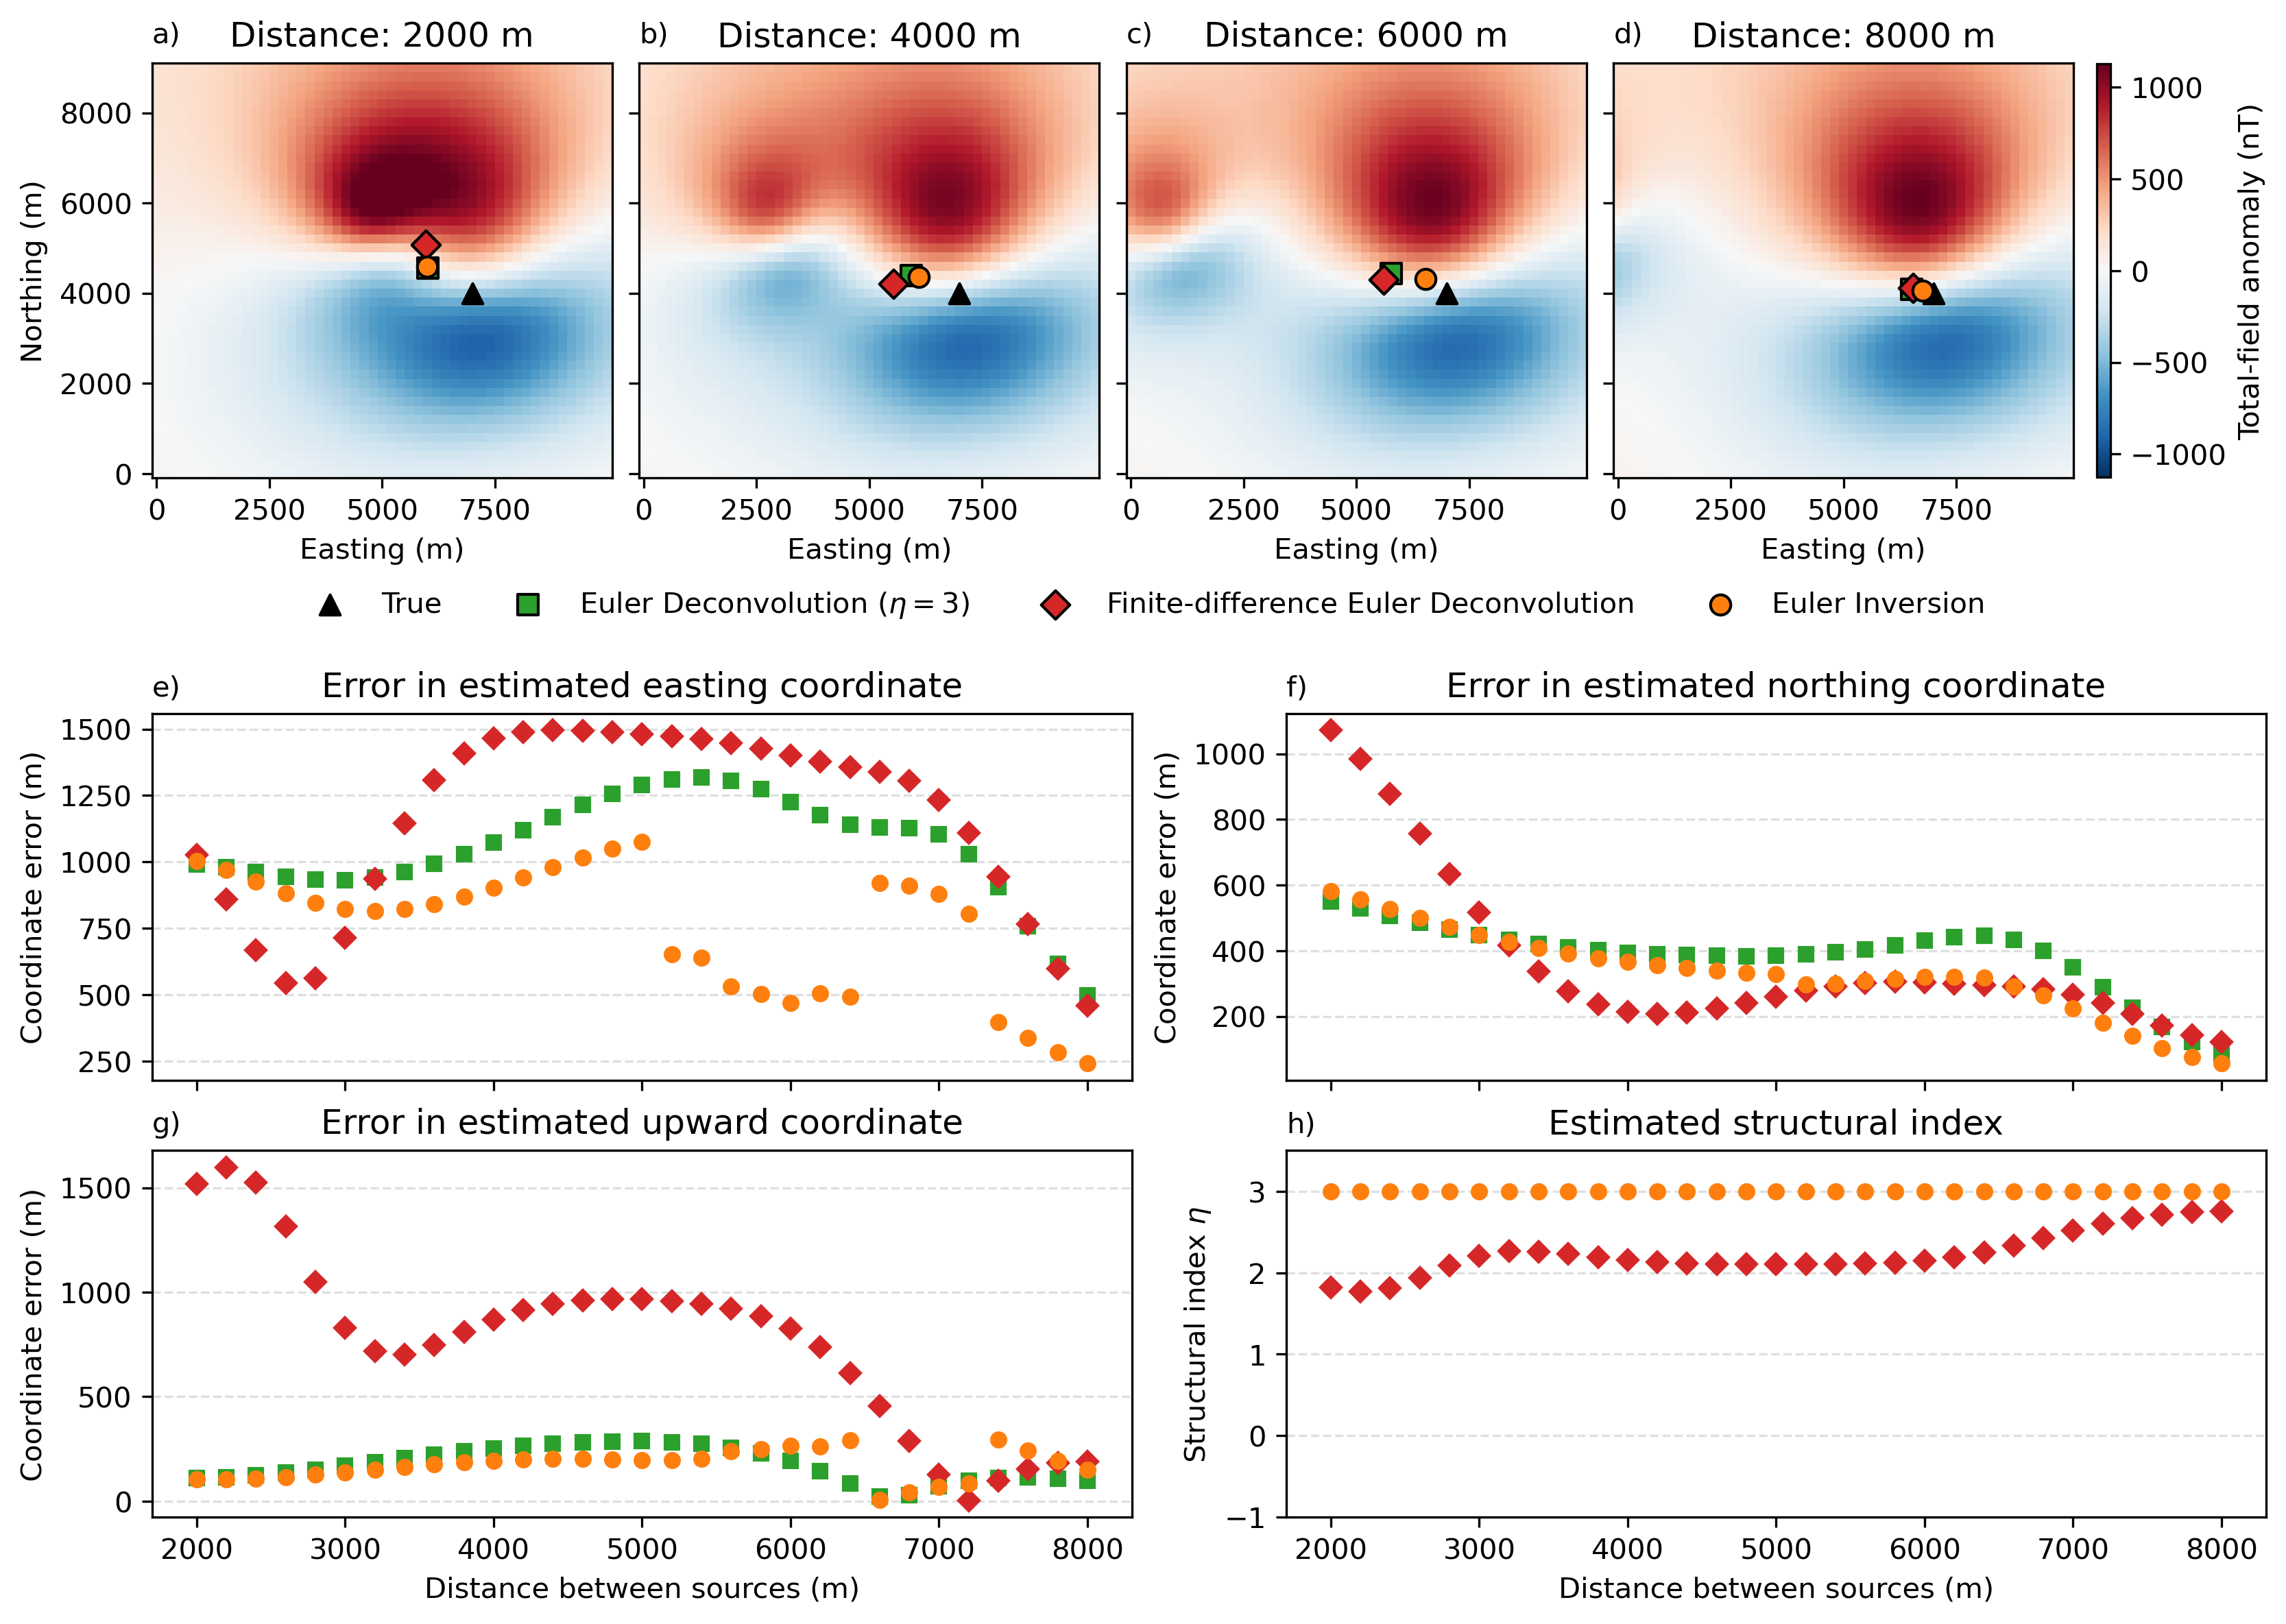

In [7]:
fig = plt.figure(figsize=(11, 8), layout="constrained")
figures = fig.subfigures(2, 1, height_ratios=[1, 1.4])

colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
marker_ei = "o"
color_ei = colors[1]
marker_ed = "s"
color_ed = colors[2]
marker_fd = "D"
color_fd = colors[3]

axes = figures[0].subplots(1, 4, sharey=True)

datasets_to_plot = [0, n_datasets // 3, 2 * n_datasets // 3, -1]
source_distance = np.abs(eastings - true_coordinates[0])
marker_size = 50
cbkwargs = dict()
scale = vd.maxabs(datasets[0].field)
for j, ax, label in zip(datasets_to_plot[::-1], axes.ravel(), "abcd"):
    ax.set_aspect("equal")
    ax.text(0, 1.05, f"{label})", transform=ax.transAxes)
    ax.set_title(f"Distance: {source_distance[j]:.0f} m")
    tmp = datasets[j].field.plot.pcolormesh(
        ax=ax,
        add_labels=False,
        add_colorbar=False,
        cmap="RdBu_r",
        vmin=-scale,
        vmax=scale,
    )
    label_true = ax.scatter(
        *true_coordinates[:2],
        c="k",
        s=marker_size,
        marker="^",
        linewidths=1,
        edgecolors="black",
    )
    label_ed = ax.scatter(
        *deconv[j].location_[:2],
        c=color_ed,
        s=marker_size,
        marker=marker_ed,
        linewidths=1,
        edgecolors="black",
    )
    label_fd = ax.scatter(
        *deconvfd[j].location_[:2],
        c=color_fd,
        s=marker_size,
        marker=marker_fd,
        linewidths=1,
        edgecolors="black",
    )
    label_ei = ax.scatter(
        *inversion[j].location_[:2],
        c=color_ei,
        s=marker_size,
        marker=marker_ei,
        linewidths=1,
        edgecolors="black",
    )
    ax.set_xlabel("Easting (m)")
    ax.set_xticks([0, 2500, 5000, 7500])
axes[0].set_ylabel("Northing (m)")
fig.colorbar(tmp, ax=axes[-1], label="Total-field anomaly (nT)", aspect=30, shrink=0.7)
figures[0].legend(
    [label_true, label_ed, label_fd, label_ei],
    [
        "True",
        "Euler Deconvolution ($\\eta=3$)",
        "Finite-difference Euler Deconvolution",
        "Euler Inversion",
    ],
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    loc="outside lower center",
    ncols=4,
)

axes = figures[1].subplots(2, 2, sharex=True).ravel()
for ax, label in zip(axes, "efgh"):
    ax.text(0, 1.05, f"{label})", transform=ax.transAxes)
    ax.grid(axis="y", alpha=0.4, linestyle="--")
for ax in axes[-2:]:
    ax.set_xlabel("Distance between sources (m)")


marker_size = 5
    
for i, (ax, coord_name) in enumerate(zip(axes[:3], ["easting", "northing", "upward"])):
    ax.set_title(f"Error in estimated {coord_name} coordinate")
    ax.set_ylabel("Coordinate error (m)")
    ax.plot(
        source_distance,
        [abs(true_coordinates[i] - e.location_[i]) for e in deconv],
        marker=marker_ed,
        color=color_ed,
        linestyle="",
        markersize=marker_size,
    )
    ax.plot(
        source_distance,
        [abs(true_coordinates[i] - e.location_[i]) for e in deconvfd],
        marker=marker_fd,
        color=color_fd,
        linestyle="",
        markersize=marker_size,
    )
    ax.plot(
        source_distance,
        [abs(true_coordinates[i] - e.location_[i]) for e in inversion],
        marker=marker_ei,
        color=color_ei,
        linestyle="",
        markersize=marker_size,
    )

ax = axes[3]
ax.set_title("Estimated structural index")
ax.set_ylabel("Structural index $\\eta$")
ax.plot(
    source_distance,
    [e.structural_index_ for e in deconvfd],
    marker=marker_fd,
    color=color_fd,
    linestyle="",
    markersize=marker_size,
)
ax.plot(
    source_distance,
    [e.structural_index for e in inversion],
    marker=marker_ei,
    color=color_ei,
    linestyle="",
    markersize=marker_size,
)
ax.set_ylim(-1, 3.5)

# Save the figure and display the saved figure because savefig and
# show can sometimes create slightly different figures
figfile = Path("..") / "paper" / "figures" / "synthetic-interfering-sources.png"
fig.savefig(figfile, dpi=300, bbox_inches="tight")
plt.close()
Image(figfile)

## Export a LaTeX file with information for the manuscript

Save things we want to include on the paper so that they can be referenced instead of copied.

In [8]:
output = rf"""
\newcommand{{\SynInterfTrueEast}}{{\qty{{{true_coordinates[0]:.0f}}}{{\m}}}}
\newcommand{{\SynInterfTrueNorth}}{{\qty{{{true_coordinates[1]:.0f}}}{{\m}}}}
\newcommand{{\SynInterfTrueUp}}{{\qty{{{true_coordinates[2]:.0f}}}{{\m}}}}
\newcommand{{\SynInterfTrueBase}}{{\qty{{{base_level:.0f}}}{{\nano\tesla}}}}
\newcommand{{\SynInterfInterfEastMax}}{{\qty{{{eastings.max():.0f}}}{{\m}}}}
\newcommand{{\SynInterfInterfEastMin}}{{\qty{{{eastings.min():.0f}}}{{\m}}}}
\newcommand{{\SynInterfInterfNorth}}{{\qty{{{interf_north:.0f}}}{{\m}}}}
\newcommand{{\SynInterfInterfUp}}{{\qty{{{interf_up:.0f}}}{{\m}}}}
\newcommand{{\SynInterfNModels}}{{{eastings.size}}}
\newcommand{{\SynInterfInt}}{{\qty{{{intensity:.0e}}}{{\ampere\per\meter}}}}
\newcommand{{\SynInterfDec}}{{\qty{{{declination:.0f}}}{{\degree}}}}
\newcommand{{\SynInterfInc}}{{\qty{{{inclination:.0f}}}{{\degree}}}}
\newcommand{{\SynInterfHeight}}{{\qty{{{height:.0f}}}{{\m}}}}
\newcommand{{\SynInterfSpacing}}{{\qty{{{spacing:.0f}}}{{\m}}}}
""".strip()
path = Path("..") / "paper" / "variables" / "synthetic-interfering-sources.tex"
path.write_text(output)
print(output)

\newcommand{\SynInterfTrueEast}{\qty{7000}{\m}}
\newcommand{\SynInterfTrueNorth}{\qty{4000}{\m}}
\newcommand{\SynInterfTrueUp}{\qty{-3000}{\m}}
\newcommand{\SynInterfTrueBase}{\qty{100}{\nano\tesla}}
\newcommand{\SynInterfInterfEastMax}{\qty{5000}{\m}}
\newcommand{\SynInterfInterfEastMin}{\qty{-1000}{\m}}
\newcommand{\SynInterfInterfNorth}{\qty{5000}{\m}}
\newcommand{\SynInterfInterfUp}{\qty{-1500}{\m}}
\newcommand{\SynInterfNModels}{31}
\newcommand{\SynInterfInt}{\qty{5e+11}{\ampere\per\meter}}
\newcommand{\SynInterfDec}{\qty{-10}{\degree}}
\newcommand{\SynInterfInc}{\qty{-30}{\degree}}
\newcommand{\SynInterfHeight}{\qty{400}{\m}}
\newcommand{\SynInterfSpacing}{\qty{200}{\m}}
